# **ESG Text Classification — Fine-Tuning a Transformer**

# Step 1 — Environment & Package Setup

**Purpose**  
Install all required Python libraries and verify the runtime configuration (Python + CUDA + GPU).  
This ensures a consistent and reproducible environment for fine-tuning and evaluation.

**Why This Is Critical**  
- **Dependency Control →** Installs exact versions of key packages (`transformers`, `datasets`, `evaluate`, `peft`, `bitsandbytes`, `gradio`, etc.) to remove “works-on-my-machine” issues.  
- **Hardware Verification →** Confirms GPU availability, VRAM, and CUDA version—essential for performance and reproducibility.  
- **Documentation →** Provides a clear record of environment and library versions required to rerun this notebook successfully.

**What This Step Accomplishes**  
- ✅ Installs all fine-tuning dependencies and pins `pandas==2.2.2` to avoid conflicts  
- ✅ Verifies Python / CUDA / GPU configuration  
- ✅ Prints core library versions for documentation  

**Expected Outcome**  
A successful run prints a system summary like:

NEW NOTEBOOK SETUP – STEP 1
==================================================
- 🐍 Python version: 3.12.12 (main)
- 🖥️ CUDA available: True
- 🎮 GPU: NVIDIA L4
- 💾 GPU Memory: 22.5 GB
- 🔢 CUDA version: 12.6
- ✅ GPU setup successful!

📦 Package Versions
---------------------------
- pandas: 2.2.2
- pyarrow: 18.1.0
- datasets: 4.0.0
- transformers: 4.57.1

In [11]:
# ==============================================================
# STEP 1 : Environment & Package Setup
# --------------------------------------------------------------
# Installs pinned dependencies and verifies full runtime setup
# ==============================================================

# --- 1️⃣ Install packages (quiet mode) ---
!pip install -q -U transformers datasets evaluate scikit-learn accelerate peft bitsandbytes gradio
!pip install -q --upgrade --no-deps "pandas==2.2.2"

# --- 2️⃣ Verify runtime environment ---
import os, sys, platform, subprocess, torch, pandas, datasets, transformers, pyarrow

cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "None"

# Query GPU memory (MB → GB)
gpu_mem = "N/A"
if cuda_available:
    try:
        smi_out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,noheader,nounits"]
        ).decode().strip()
        gpu_mem = f"{float(smi_out.split()[0]) / 1024:.1f} GB"
    except Exception:
        gpu_mem = "N/A"

cuda_ver = torch.version.cuda or "N/A"

# --- 3️⃣ Display summary banner ---
print("NEW NOTEBOOK SETUP – STEP 1")
print("=" * 50)
print(f"🐍 Python version: {sys.version.split()[0]} ({platform.python_build()[0]})")
print(f"🖥️ CUDA available: {cuda_available}")
print(f"🎮 GPU: {gpu_name}")
print(f"💾 GPU Memory: {gpu_mem}")
print(f"🔢 CUDA version: {cuda_ver}")
print("✅ GPU setup successful!\n")

# --- 4️⃣ Log core package versions for reproducibility ---
print("📦 Package Versions")
print("---------------------------")
print("pandas:", pandas.__version__)
print("pyarrow:", pyarrow.__version__)
print("datasets:", datasets.__version__)
print("transformers:", transformers.__version__)



NEW NOTEBOOK SETUP – STEP 1
🐍 Python version: 3.12.12 (main)
🖥️ CUDA available: True
🎮 GPU: NVIDIA L4
💾 GPU Memory: 22.5 GB
🔢 CUDA version: 12.6
✅ GPU setup successful!

📦 Package Versions
---------------------------
pandas: 2.2.2
pyarrow: 18.1.0
datasets: 4.0.0
transformers: 4.57.1


# Step 2 — Project Configuration & Reproducibility

**Purpose**  
Define all project-wide settings (dataset, text/label columns, model, LoRA toggle, max length, output paths) and set reproducibility controls.

**Why This Is Critical**  
- **Single Source of Truth:** Centralizing config prevents silent drift between cells.  
- **Reproducibility:** Fixed seeds and (optional) deterministic flags reduce run-to-run variance.  
- **Clarity:** Explicitly documents dataset fields and model choice for graders.

**What This Step Accomplishes**  
- ✅ Imports all modules used downstream (HF Datasets/Transformers, PEFT/LoRA, metrics, plots)  
- ✅ Sets a global `SEED` and applies it across Python/NumPy/PyTorch (+ CUDA if present)  
- ✅ Declares core config: dataset name, column names, base model, LoRA usage, max sequence length, and output directory  
- ✅ Prints a compact config summary to include in your report

**Expected Outcomes**  
- “✅ Setup complete”  
- Printed configuration block showing: dataset/model, columns, LoRA flag, max length, device, and output path


In [13]:
# ==============================================================
# STEP 2 : Project Configuration & Reproducibility
# --------------------------------------------------------------
# Centralizes config (dataset, columns, model, LoRA, paths) and
# applies reproducibility controls (seeds, CUDA seeding).
# ==============================================================

# ---- Core imports ----
from datasets import load_dataset, load_from_disk, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, pipeline
)
from peft import LoraConfig, get_peft_model
import evaluate, numpy as np, pandas as pd, re, html, torch, os, random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from pprint import pprint
import matplotlib.pyplot as plt

# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Optional: stronger determinism (slightly slower). Toggle if your rubric favors determinism.
DETERMINISTIC = True
if DETERMINISTIC:
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    except Exception as _e:
        # Safe to continue even if determinism can't be fully enforced on this GPU/runtime
        pass

# Reduce tokenizer thread noise & ensure stable hashing
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---- Project config ----
DATASET_NAME = "FinanceMTEB/ESG"   # <-- swap if you change domains
TEXT_COL     = "text"               # <-- update if your dataset uses a different text field
LABEL_COL    = "label"              # <-- update if your dataset uses a different label field

BASE_MODEL   = "ProsusAI/finbert"   # domain-tuned base model for finance text
USE_LORA     = True                 # toggle LoRA (PEFT) to reduce trainable params
MAX_LEN      = 256                  # tokenizer max sequence length

OUTPUT_DIR   = "/content/esg_ckpt"  # persisted artifacts (model, tokenizer, metrics)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- Device summary (for quick audit in the report) ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name(0) if DEVICE == "cuda" else "CPU"

print("=== PROJECT CONFIG ====================================")
print(f"Dataset          : {DATASET_NAME}")
print(f"Columns          : TEXT_COL='{TEXT_COL}', LABEL_COL='{LABEL_COL}'")
print(f"Base model       : {BASE_MODEL}")
print(f"LoRA (PEFT)      : {USE_LORA}")
print(f"Max sequence len : {MAX_LEN}")
print(f"Output dir       : {OUTPUT_DIR}")
print(f"Device           : {DEVICE} ({device_name})")
print(f"Seed             : {SEED}  | Deterministic: {DETERMINISTIC}")
print("=======================================================")
print("✅ Setup complete")


=== PROJECT CONFIG ====================================
Dataset          : FinanceMTEB/ESG
Columns          : TEXT_COL='text', LABEL_COL='label'
Base model       : ProsusAI/finbert
LoRA (PEFT)      : True
Max sequence len : 256
Output dir       : /content/esg_ckpt
Device           : cuda (NVIDIA L4)
Seed             : 42  | Deterministic: True
✅ Setup complete


# Step 3 — Load Raw Dataset (Minimal)

**Purpose**  
Load the ESG dataset into memory so we can clean and split it in the next step.

**Why This Is Critical**  
- You can’t preprocess or fine-tune until the raw data is in memory.
- A quick peek confirms the dataset loaded correctly.

**What This Step Accomplishes**  
- ✅ Loads `FinanceMTEB/ESG` (or your configured `DATASET_NAME`)
- ✅ Selects the single `train` split as `raw_split`
- ✅ Prints size and a tiny sample for sanity check

**Expected Outcome**  
- A `Dataset` object printed with ~3k rows
- A couple of sample rows (text + label)


In [16]:
# ==============================================================
# STEP 3 : Load Raw Dataset
# ==============================================================

raw = load_dataset(DATASET_NAME)          # e.g., "FinanceMTEB/ESG"
raw_split = raw["train"]                  # we’ll create our own splits next
print(raw_split)                          # show HF Dataset summary

# Tiny peek (non-intrusive)
for i in range(2):
    ex = raw_split[i]
    print(f"\nSample {i+1}")
    print("TEXT :", (ex[TEXT_COL] or "")[:200].replace("\n", " "))
    print("LABEL:", ex[LABEL_COL])

print("\n✅ Data loaded.")


Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 3000
})

Sample 1
TEXT : This explains the increase in high-risk events in 2017, and the subsequent improvement in 2018 and 2019, as the action items implemented supported the decreasing number of high-risk incidents.
LABEL: 3

Sample 2
TEXT : Focusing on shared value creation in 2019 allowed us to contribute to economic growth and enhance life’s possibilities for our stakeholders.
LABEL: 3

✅ Data loaded.


# Step 4 — Text Cleaning Helper

**Purpose**  
Provide a reusable function to normalize raw text before tokenization (remove HTML, redact PII, collapse whitespace).

**Why This Is Critical**  
- **Signal > Noise:** Cleaner inputs improve model generalization and reduce spurious tokens.  
- **Privacy:** Redacts emails, URLs, and phone numbers to avoid memorization of PII.  
- **Consistency:** Standardized formatting helps the tokenizer and stabilizes training.

**What This Step Accomplishes**  
- ✅ Defines `clean_text(...)` with PII redaction and HTML/tag removal  
- ✅ Handles `None`/empty strings safely  
- ✅ Collapses whitespace to a single space for consistent tokenization

**Expected Outcome**  
- “✅ Cleaning helper ready” printed  
- Calling `clean_text("Contact me at a@b.com <b>now</b> https://x.y")` returns  
  `"Contact me at <EMAIL> now <URL>"`


In [19]:
# ==============================================================
# STEP 4 : Text Cleaning Helper
# --------------------------------------------------------------
# Removes HTML tags, redacts PII (emails, URLs, phone numbers),
# and normalizes whitespace to prepare clean inputs for modeling.
# ==============================================================

def clean_text(t: str) -> str:
    """
    Normalize raw text for modeling.

    Operations:
      - HTML entity unescape (e.g., &amp; → &)
      - Strip HTML tags (e.g., <b> → "")
      - Redact PII: emails → <EMAIL>, URLs → <URL>, phone numbers → <PHONE>
      - Collapse all whitespace to single spaces
      - Trim leading/trailing whitespace

    Args:
      t: Raw text (may be None/empty)

    Returns:
      Cleaned text string suitable for tokenization.
    """
    t = html.unescape(t or "")
    t = re.sub(r"<[^>]+>", " ", t)                              # strip HTML tags
    t = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", "<EMAIL>", t)     # emails
    t = re.sub(r"https?://\S+", "<URL>", t)                     # urls
    t = re.sub(r"\b(?:\+?\d[ \-()]?){7,}\b", "<PHONE>", t)     # phones (simple heuristic)
    t = re.sub(r"\s+", " ", t).strip()                          # normalize whitespace
    return t

print("✅ Cleaning helper ready")


✅ Cleaning helper ready


# Step 5 — Normalize, Filter, and Deduplicate

**Purpose**  
Standardize text (Unicode + case), remove noisy/too-short samples, and drop duplicate `(text, label)` pairs to improve data quality before tokenization.

**Why This Is Critical**  
- **Normalization:** Unicode NFKC + lowercasing reduces spurious token variants (e.g., “ﬁ”, full-width chars).  
- **Noise Control:** Very short strings tend to be headers/boilerplate and can harm learning.  
- **Leak Prevention:** Removing duplicates avoids inflating metrics and leaking identical rows across splits.

**What This Step Accomplishes**  
- ✅ Applies `unicodedata.normalize("NFKC", …)` and `lower().strip()`  
- ✅ Filters rows with `len(text) < MIN_LEN`  
- ✅ Drops duplicate `(text, label)` rows and reports before/after counts  
- ✅ Produces a clean `raw_clean` dataset for the next step (label normalization + stratified split)

**Expected Outcomes**  
- A “Dedup: X -> Y rows” line showing reduction (Y ≤ X)  
- `raw_clean` contains only normalized, non-trivial, unique samples


In [20]:
# ==============================================================
# STEP 5 : Normalize, Filter, and Deduplicate
# --------------------------------------------------------------
# - Normalize text: Unicode NFKC + lowercase + trim
# - Remove very short/noisy rows
# - Drop duplicate (text, label) rows
# - Emit a clean Dataset: `raw_clean`
# ==============================================================

import unicodedata, pandas as pd
from datasets import Dataset

def normalize_text(t: str) -> str:
    """
    Normalize text to reduce spurious variants before tokenization.
    - Unicode compatibility decomposition/composition (NFKC)
    - Lowercase
    - Trim whitespace
    """
    t = unicodedata.normalize("NFKC", str(t))
    return t.lower().strip()

# 1) Normalize text column in-place
raw_split = raw_split.map(lambda ex: {TEXT_COL: normalize_text(ex[TEXT_COL])})

# 2) Drop very short/noisy rows (length threshold tuned for your domain)
MIN_LEN = 12
raw_split = raw_split.filter(lambda ex: len(ex[TEXT_COL]) >= MIN_LEN)

# 3) Global deduplication on (text, label)
df_all = raw_split.to_pandas()
before = len(df_all)
df_all = df_all.drop_duplicates(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
after = len(df_all)
print(f"Dedup: {before} -> {after} rows")

# Convert back to HF Dataset
raw_clean = Dataset.from_pandas(df_all, preserve_index=False)
print(raw_clean)
print("✅ Cleaned dataset ready: `raw_clean`")


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dedup: 3000 -> 3000 rows
Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 3000
})
✅ Cleaned dataset ready: `raw_clean`


# Step 6 — Final Clean → Stratified 80/10/10 Splits + Label Schema

**Purpose**  
Finish data hygiene, build **stratified Train/Val/Test (80/10/10)** by **indices** (avoids value-based surprises), and formalize the label schema with `ClassLabel`.

**Why This Is Critical**  
- **Stratification:** Preserves class balance across splits for fair evaluation.  
- **Index-Based Selection:** Robust to duplicate rows / pyarrow typing issues.  
- **Consistent Labels:** Using `ClassLabel` ensures a stable id↔name mapping (required by the model head and metrics code).

**What This Step Accomplishes**  
- ✅ Applies a final filter + text cleaning pass (safety net)  
- ✅ Derives sorted label names and creates `ClassLabel`  
- ✅ Builds a `DatasetDict({train, validation, test})` using **stratified** indices  
- ✅ Casts the label column in each split to `ClassLabel`  
- ✅ Prints per-split class distributions for sanity

**Expected Outcomes**  
- A `DatasetDict` printed with three splits and sizes summing to the total  
- A line `Labels: [...]` with stable ordering  
- Per-split label histograms (counts are similar across splits)  
- Final message: `✅ Data cleaned, split by indices, and labels cast`


In [21]:
# ==============================================================
# STEP 6 : Final Clean → Stratified 80/10/10 + Label Schema
# --------------------------------------------------------------
# - Safe final filter + cleaning pass
# - Build stratified 80/10/10 splits via indices (train/val/test)
# - Cast label column to HF ClassLabel for stable id↔name mapping
# ==============================================================

from datasets import DatasetDict, ClassLabel
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np

# Prefer the already-normalized/deduped dataset if available
_base = "raw_clean" if "raw_clean" in globals() else "raw_split"
print(f"Using base dataset: {_base}")
data_base = raw_clean if _base == "raw_clean" else raw_split

# 1) Final safety pass: keep rows with both text & label, re-apply text cleaner
data_base = data_base.filter(lambda ex: bool(ex.get(TEXT_COL)) and ex.get(LABEL_COL) is not None)
data_base = data_base.map(lambda ex: {TEXT_COL: clean_text(ex[TEXT_COL])})

# 2) Build label vocabulary (sorted → stable order)
labels = sorted(list(set(data_base[LABEL_COL])))
class_label = ClassLabel(num_classes=len(labels), names=labels)
print("Labels:", labels)

# 3) Stratified split by indices (80/10/10)
N = len(data_base)
all_idx = np.arange(N)
y_all = list(data_base[LABEL_COL])  # py list; supports str or int labels

# train vs temp (80/20)
train_idx, temp_idx = train_test_split(
    all_idx, test_size=0.20, stratify=y_all, random_state=SEED
)
# val vs test (split the remaining 20% → 10/10 total)
y_temp = [y_all[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, stratify=y_temp, random_state=SEED
)

# 4) Materialize splits by index (robust to duplicates & pyarrow types)
ds = DatasetDict({
    "train":      data_base.select(train_idx.tolist()),
    "validation": data_base.select(val_idx.tolist()),
    "test":       data_base.select(test_idx.tolist()),
})

# 5) Ensure label dtype is ClassLabel (stable id↔name mapping)
for split in ds:
    ds[split] = ds[split].cast_column(LABEL_COL, class_label)

# 6) Quick sanity: per-split class distributions
for split in ds:
    counts = Counter(ds[split][LABEL_COL])
    print(split, dict(counts))

print("✅ Data cleaned, split by indices, and labels cast")


Using base dataset: raw_clean


Filter:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Labels: [0, 1, 2, 3]


Casting the dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

train {3: 642, 2: 1202, 0: 487, 1: 69}
validation {2: 151, 3: 80, 0: 61, 1: 8}
test {2: 150, 3: 80, 0: 61, 1: 9}
✅ Data cleaned, split by indices, and labels cast


# Step 7 — Tokenization & Collation

**Purpose**  
Convert clean text into model-ready token IDs and define a dynamic padding strategy for efficient mini-batching.

**Why This Is Critical**  
- **Consistent Inputs:** Tokenization (truncate to `MAX_LEN`) prevents shape errors and OOMs.  
- **Efficiency:** A `DataCollatorWithPadding` applies **dynamic padding** per batch, saving memory and improving speed vs. padding everything to `MAX_LEN`.  
- **Schema Integrity:** Verifies `num_labels` and human-readable `label_names` from the dataset’s `ClassLabel`.

**What This Step Accomplishes**  
- ✅ Loads the tokenizer for your `BASE_MODEL` (fast tokenizer)  
- ✅ Maps raw text → token IDs with truncation and max length  
- ✅ Sets a collator for dynamic padding at train time  
- ✅ Confirms label space (`num_labels`, `label_names`) for the classifier head

**Expected Outcomes**  
- “Label names: [...]” printed with stable class names  
- “✅ Tokenization complete”


In [22]:
# ==============================================================
# STEP 7 : Tokenization & Collation
# --------------------------------------------------------------
# - Tokenize text into input IDs/attention masks with truncation
# - Use dynamic padding at batch time for efficiency
# - Confirm label schema (num_labels, label_names)
# ==============================================================

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)

def tok(batch):
    # Truncate to MAX_LEN; padding is deferred to the collator (dynamic per batch)
    return tokenizer(batch[TEXT_COL], truncation=True, max_length=MAX_LEN)

# Map over all splits; drop raw text to reduce memory (optional but cleaner)
remove_cols = [c for c in ds["train"].column_names if c not in (LABEL_COL,)]
ds_tok = ds.map(tok, batched=True, remove_columns=remove_cols)

# Dynamic padding at batch time (avoids padding the entire dataset to MAX_LEN)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Extract label metadata from ClassLabel feature
num_labels = ds_tok["train"].features[LABEL_COL].num_classes
label_names = ds_tok["train"].features[LABEL_COL].names

print("Label names:", label_names)
print("✅ Tokenization complete")


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Label names: [0, 1, 2, 3]
✅ Tokenization complete


# Step 8 — Metrics (Accuracy + Macro-F1)

**Purpose**  
Define evaluation metrics for validation/test to quantify overall performance and class-balance robustness.

**Why This Is Critical**  
- **Accuracy** is intuitive but can be misleading with class imbalance.  
- **Macro-F1** averages F1 across classes, giving minority classes equal weight — better reflects balanced performance.

**What This Step Accomplishes**  
- ✅ Loads `evaluate` metrics for **accuracy** and **f1**  
- ✅ Implements `compute_metrics(...)` for Hugging Face `Trainer`  
- ✅ Returns both metrics per evaluation step (used for model selection if configured)

**Expected Outcomes**  
- Console prints: `✅ Metrics ready (accuracy, macro-F1)`  
- During training/eval, logs show keys like: `eval_accuracy`, `eval_f1`


In [23]:
# ==============================================================
# STEP 8 : Metrics (Accuracy + Macro-F1)
# --------------------------------------------------------------
# - Accuracy: overall correctness
# - Macro-F1: class-balanced performance (important for imbalance)
# - Provides `compute_metrics` callback for Hugging Face Trainer
# ==============================================================

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics from model logits and reference labels.

    Args:
        eval_pred: Tuple (logits, labels) provided by HF Trainer.
                   - logits: np.ndarray [batch, num_labels]
                   - labels: np.ndarray [batch]

    Returns:
        dict with:
          - 'accuracy': overall accuracy
          - 'f1': macro-averaged F1 score (equal weight per class)
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    out = {}
    out.update(metric_acc.compute(predictions=preds, references=labels))
    out.update(metric_f1.compute(predictions=preds, references=labels, average="macro"))
    return out

print("✅ Metrics ready (accuracy, macro-F1)")


✅ Metrics ready (accuracy, macro-F1)


# Step 9 — Training with Hugging Face `Trainer`

**Purpose**  
Launch fine-tuning with a resilient `TrainingArguments` builder that works across different `transformers` versions, evaluates each epoch, and tracks the **best model by Macro-F1**.

**Why This Is Critical**  
- **Version Differences:** Colab images can ship slightly different `transformers` builds; argument names (e.g., `evaluation_strategy`) may vary.  
- **Reliable Selection:** `load_best_model_at_end=True` + `metric_for_best_model="f1"` ensures we keep the top checkpoint by **Macro-F1** (from Step 8).  
- **Clear Logging:** Per-epoch evaluation and periodic logging make training progress auditable.

**What This Step Accomplishes**  
- ✅ Builds `TrainingArguments` with graceful fallbacks for eval/save scheduling  
- ✅ (Auto)-Creates the classification model if it hasn’t been instantiated yet  
- ✅ Trains on `ds_tok["train"]`, evaluates on `ds_tok["validation"]` each epoch  
- ✅ Prints final validation metrics (and keeps best checkpoint in `OUTPUT_DIR`)

**Expected Outcomes**  
- A training log with `eval_accuracy` and `eval_f1` per epoch  
- A final `📊 Validation metrics:` block showing `eval_accuracy`, `eval_f1`, etc.  
- `✅ Training complete` and a best model saved under `OUTPUT_DIR`


In [11]:
# ==============================================================
# STEP 9 : Train with Hugging Face Trainer
# --------------------------------------------------------------
# - Builds TrainingArguments with fallbacks for older/newer APIs
# - Ensures a model exists (creates from BASE_MODEL if missing)
# - Trains and evaluates per epoch; keeps best by Macro-F1
# ==============================================================

# --- Safety: ensure model is defined ---
if "model" not in globals():
    # Create the classification head with correct label mappings
    model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL,
        num_labels=num_labels,
        id2label={i: name for i, name in enumerate(label_names)},
        label2id={name: i for i, name in enumerate(label_names)},
    ).to(DEVICE)

# Optional: Apply LoRA (PEFT) if toggled
if USE_LORA:
    # A simple, strong default LoRA config for classification heads
    lora_cfg = LoraConfig(
        r=8,              # rank
        lora_alpha=16,    # scaling
        lora_dropout=0.05,
        bias="none",
        task_type="SEQ_CLS",
    )
    model = get_peft_model(model, lora_cfg)

# --- Robust TrainingArguments builder that works across transformer versions ---
from transformers.training_args import TrainingArguments as HFTrainingArguments
try:
    from transformers import IntervalStrategy
    EVAL_STRAT = IntervalStrategy.EPOCH
except Exception:
    EVAL_STRAT = "epoch"  # string fallback

def build_training_args(**base):
    """
    Try to construct TrainingArguments with evaluation/save strategy.
    Falls back gracefully if the current class doesn't accept those kwargs.
    """
    try:
        return HFTrainingArguments(evaluation_strategy=EVAL_STRAT,
                                   save_strategy=EVAL_STRAT, **base)
    except TypeError:
        try:
            # Some very old versions used eval_strategy
            return HFTrainingArguments(eval_strategy=EVAL_STRAT,
                                       save_strategy=EVAL_STRAT, **base)
        except TypeError:
            # Last resort: rely on manual evaluation after training
            return HFTrainingArguments(**base)

base_kwargs = dict(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,    # keeps best checkpoint by metric_for_best_model
    metric_for_best_model="f1",     # this matches the 'f1' key in compute_metrics (Macro-F1)
    greater_is_better=True,
    # Use a list to avoid "report_to='none'" issues across versions
    report_to=[],                   # disable external loggers by default
    fp16=torch.cuda.is_available(), # AMP when GPU is present
    logging_steps=50,
    seed=SEED,
    save_total_limit=2,             # keep disk usage sane
)

args = build_training_args(**base_kwargs)

# --- Trainer ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

print("🚀 Starting training…")
train_out = trainer.train()

# If eval scheduling wasn't accepted, we still run a manual eval here
print("📊 Validation metrics:")
val_metrics = trainer.evaluate(ds_tok["validation"])
from pprint import pprint as _pprint
_pprint(val_metrics)

print("✅ Training complete")


/tmp/ipython-input-2768931073.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Starting training…


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.224100,1.156995,0.526667,0.287082
2,0.969300,0.929913,0.620000,0.358343
3,0.836100,0.811145,0.710000,0.448123
4,0.734100,0.745061,0.730000,0.468950
5,0.747700,0.723636,0.733333,0.475242


📊 Validation metrics:


{'epoch': 5.0,
 'eval_accuracy': 0.7333333333333333,
 'eval_f1': 0.47524229437365856,
 'eval_loss': 0.7236360907554626,
 'eval_runtime': 0.3615,
 'eval_samples_per_second': 829.946,
 'eval_steps_per_second': 27.665}
✅ Training complete


# Step 10 — Hyperparameter Optimization (HPO)

**Purpose**  
Define and execute a clear strategy to explore hyperparameters and select the best configuration for validation performance.

**Strategy**  
- **Search method:** Grid search over *learning rate × epochs × batch size*.  
- **Search space (example):**
  - `learning_rate`: {2e-5, 3e-5, 5e-5}
  - `num_train_epochs`: {3, 5}
  - `per_device_train_batch_size`: {8, 16}
  → **Total configs tested:** 3 × 2 × 2 = **12** (≥ 3 as required)
- **Fresh model per trial:** Re-initialize base model (and apply LoRA if enabled) for each run to avoid cross-run leakage.
- **Data:** Train on `train`, evaluate on `validation`. Same seed (`SEED=42`) for fairness.
- **Selection criterion:** **Validation Macro-F1** (class-balanced metric).
- **Outputs & Logging:** Each run logs `Val_Accuracy`, `Val_F1`, `TrainSeconds`.  
  Results are saved to **`{OUTPUT_DIR}/hpo_results.csv`** and summarized in a table/plot.

**Why Macro-F1?**  
- Accuracy can overstate performance with class imbalance. **Macro-F1** weights each class equally, making it a better selection metric for ESG text classification.

**Expected Outcomes**  
- A sorted results table (top rows by `Val_F1`) and a bar chart comparing configurations.  
- Clear identification of the **best configuration** with explicit values (LR, Epochs, BatchSize).  
- CSV artifact for grading and reproducibility.


In [24]:
# ==============================================================
# STEP 10 : HPO grid (LR × epochs × batch size) → select best by Val_F1
# --------------------------------------------------------------
# - Builds a fresh model per trial (with optional LoRA)
# - Trains and evaluates on validation
# - Records metrics/time; saves results CSV; exposes best config
# ==============================================================

import itertools, os, gc, time
import numpy as np
import torch
import pandas as pd
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
import transformers

print("Transformers version:", transformers.__version__)
print("Starting HPO grid...")

# --- helper: build a brand-new model for each run (with optional LoRA) ---
def build_fresh_model():
    """
    Create a new classifier head from BASE_MODEL with correct label maps.
    Applies LoRA when USE_LORA is True.
    """
    m = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL,
        num_labels=num_labels,
        id2label={i: name for i, name in enumerate(label_names)},
        label2id={name: i for i, name in enumerate(label_names)},
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True,
    )
    if USE_LORA:
        from peft import LoraConfig, get_peft_model
        # Target common attention/projection modules (model-agnostic default)
        peft_cfg = LoraConfig(
            r=8, lora_alpha=16, lora_dropout=0.10,
            target_modules=["query", "key", "value", "dense"],  # safe default
            bias="none",
            task_type="SEQ_CLS",
        )
        m = get_peft_model(m, peft_cfg)
    return m

# --- search space (adjust as needed) ---
search_space = {
    "learning_rate": [2e-5, 3e-5, 5e-5],
    "num_train_epochs": [3, 5],
    "per_device_train_batch_size": [8, 16],
}

results, config_id = [], 0

for lr, ep, bs in itertools.product(
    search_space["learning_rate"],
    search_space["num_train_epochs"],
    search_space["per_device_train_batch_size"]
):
    config_id += 1
    print(f"\n===== Run {config_id}: LR={lr}, Epochs={ep}, BS={bs} =====")
    t0 = time.time()

    args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/run_{config_id}",
        num_train_epochs=ep,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        learning_rate=lr,
        weight_decay=0.01,
        logging_dir=f"./logs/run_{config_id}",
        logging_steps=50,
        save_strategy="no",      # keep disk small; we evaluate explicitly
        report_to=[],            # avoid external loggers
        disable_tqdm=True,
        seed=SEED,
        data_seed=SEED,
        fp16=torch.cuda.is_available(),
    )

    this_model = build_fresh_model()

    trainer_hpo = Trainer(
        model=this_model,
        args=args,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["validation"],
        compute_metrics=compute_metrics,
        data_collator=collator,
        tokenizer=tokenizer,
    )

    trainer_hpo.train()
    eval_result = trainer_hpo.evaluate()

    elapsed = time.time() - t0
    row = {
        "Run": config_id,
        "LR": lr,
        "Epochs": ep,
        "BatchSize": bs,
        "Val_Accuracy": float(eval_result.get("eval_accuracy", np.nan)),
        "Val_F1": float(eval_result.get("eval_f1", np.nan)),
        "TrainSeconds": round(elapsed, 2),
    }
    results.append(row)
    print("Result:", row)

    # cleanup to save VRAM
    del trainer_hpo, this_model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- results dataframe + save ---
df_hpo = pd.DataFrame(results).sort_values("Val_F1", ascending=False)
csv_path = os.path.join(OUTPUT_DIR, "hpo_results.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)
df_hpo.to_csv(csv_path, index=False)
print("HPO results saved to:", csv_path)

# Display top configs
try:
    from IPython.display import display
    display(df_hpo.head(10))
except Exception:
    print(df_hpo.head(10).to_string(index=False))

# --- expose best config for the next cell ---
best_row = df_hpo.iloc[0]
best_lr = float(best_row["LR"])
best_ep = int(best_row["Epochs"])
best_bs = int(best_row["BatchSize"])
print(f"✅ Best HPO config → LR={best_lr}, Epochs={best_ep}, BatchSize={best_bs}")


Transformers version: 4.57.1
Starting HPO grid...

===== Run 1: LR=2e-05, Epochs=3, BS=8 =====


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: 

{'loss': 1.4107, 'grad_norm': 7.159256458282471, 'learning_rate': 1.8911111111111115e-05, 'epoch': 0.16666666666666666}
{'loss': 1.3117, 'grad_norm': 4.880201816558838, 'learning_rate': 1.7800000000000002e-05, 'epoch': 0.3333333333333333}
{'loss': 1.2121, 'grad_norm': 5.727779388427734, 'learning_rate': 1.668888888888889e-05, 'epoch': 0.5}
{'loss': 1.1144, 'grad_norm': 4.252295017242432, 'learning_rate': 1.5577777777777777e-05, 'epoch': 0.6666666666666666}
{'loss': 0.9914, 'grad_norm': 6.231479167938232, 'learning_rate': 1.4466666666666668e-05, 'epoch': 0.8333333333333334}
{'loss': 0.8719, 'grad_norm': 5.60634708404541, 'learning_rate': 1.3355555555555557e-05, 'epoch': 1.0}
{'loss': 0.8779, 'grad_norm': 5.915280342102051, 'learning_rate': 1.2244444444444445e-05, 'epoch': 1.1666666666666667}
{'loss': 0.8226, 'grad_norm': 4.0124616622924805, 'learning_rate': 1.1133333333333334e-05, 'epoch': 1.3333333333333333}
{'loss': 0.7661, 'grad_norm': 6.10414457321167, 'learning_rate': 1.00222222222

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3843, 'grad_norm': 3.7931718826293945, 'learning_rate': 1.782222222222222e-05, 'epoch': 0.3333333333333333}
{'loss': 1.2344, 'grad_norm': 5.41926908493042, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.6666666666666666}
{'loss': 1.0656, 'grad_norm': 4.035400390625, 'learning_rate': 1.3377777777777778e-05, 'epoch': 1.0}
{'loss': 1.0108, 'grad_norm': 4.7380242347717285, 'learning_rate': 1.1155555555555556e-05, 'epoch': 1.3333333333333333}
{'loss': 0.9671, 'grad_norm': 3.364192008972168, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.6666666666666665}
{'loss': 0.9141, 'grad_norm': 4.04527473449707, 'learning_rate': 6.711111111111111e-06, 'epoch': 2.0}
{'loss': 0.8771, 'grad_norm': 3.477421998977661, 'learning_rate': 4.488888888888889e-06, 'epoch': 2.3333333333333335}
{'loss': 0.8938, 'grad_norm': 5.221088886260986, 'learning_rate': 2.266666666666667e-06, 'epoch': 2.6666666666666665}
{'loss': 0.8582, 'grad_norm': 3.1481752395629883, 'learning_rate': 4.444444444444445e-

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3918, 'grad_norm': 6.2891926765441895, 'learning_rate': 1.934666666666667e-05, 'epoch': 0.16666666666666666}
{'loss': 1.2721, 'grad_norm': 6.012954235076904, 'learning_rate': 1.8680000000000004e-05, 'epoch': 0.3333333333333333}
{'loss': 1.1603, 'grad_norm': 6.976839065551758, 'learning_rate': 1.8013333333333333e-05, 'epoch': 0.5}
{'loss': 1.0529, 'grad_norm': 5.796876907348633, 'learning_rate': 1.7346666666666668e-05, 'epoch': 0.6666666666666666}
{'loss': 0.9503, 'grad_norm': 8.673041343688965, 'learning_rate': 1.668e-05, 'epoch': 0.8333333333333334}
{'loss': 0.8576, 'grad_norm': 4.93409538269043, 'learning_rate': 1.6013333333333335e-05, 'epoch': 1.0}
{'loss': 0.8686, 'grad_norm': 5.264705181121826, 'learning_rate': 1.5346666666666667e-05, 'epoch': 1.1666666666666667}
{'loss': 0.8181, 'grad_norm': 3.0795509815216064, 'learning_rate': 1.4680000000000002e-05, 'epoch': 1.3333333333333333}
{'loss': 0.7546, 'grad_norm': 6.4759368896484375, 'learning_rate': 1.4013333333333334e-05,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.4032, 'grad_norm': 3.463843822479248, 'learning_rate': 1.8693333333333333e-05, 'epoch': 0.3333333333333333}
{'loss': 1.2542, 'grad_norm': 4.1786017417907715, 'learning_rate': 1.736e-05, 'epoch': 0.6666666666666666}
{'loss': 1.1043, 'grad_norm': 4.547983169555664, 'learning_rate': 1.6026666666666667e-05, 'epoch': 1.0}
{'loss': 0.9786, 'grad_norm': 4.229866027832031, 'learning_rate': 1.4693333333333336e-05, 'epoch': 1.3333333333333333}
{'loss': 0.8987, 'grad_norm': 3.464517831802368, 'learning_rate': 1.3360000000000003e-05, 'epoch': 1.6666666666666665}
{'loss': 0.8277, 'grad_norm': 5.104947090148926, 'learning_rate': 1.202666666666667e-05, 'epoch': 2.0}
{'loss': 0.7665, 'grad_norm': 2.610874652862549, 'learning_rate': 1.0693333333333333e-05, 'epoch': 2.3333333333333335}
{'loss': 0.754, 'grad_norm': 4.923298358917236, 'learning_rate': 9.360000000000002e-06, 'epoch': 2.6666666666666665}
{'loss': 0.7112, 'grad_norm': 2.4890637397766113, 'learning_rate': 8.026666666666667e-06, 'ep

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3858, 'grad_norm': 7.217004776000977, 'learning_rate': 2.8366666666666667e-05, 'epoch': 0.16666666666666666}
{'loss': 1.2606, 'grad_norm': 4.775179862976074, 'learning_rate': 2.6700000000000002e-05, 'epoch': 0.3333333333333333}
{'loss': 1.083, 'grad_norm': 6.7242631912231445, 'learning_rate': 2.5033333333333333e-05, 'epoch': 0.5}
{'loss': 0.954, 'grad_norm': 5.14736795425415, 'learning_rate': 2.3366666666666668e-05, 'epoch': 0.6666666666666666}
{'loss': 0.8399, 'grad_norm': 6.893834114074707, 'learning_rate': 2.1700000000000002e-05, 'epoch': 0.8333333333333334}
{'loss': 0.7428, 'grad_norm': 5.1623687744140625, 'learning_rate': 2.0033333333333334e-05, 'epoch': 1.0}
{'loss': 0.7687, 'grad_norm': 4.68717098236084, 'learning_rate': 1.8366666666666668e-05, 'epoch': 1.1666666666666667}
{'loss': 0.7296, 'grad_norm': 3.481621503829956, 'learning_rate': 1.67e-05, 'epoch': 1.3333333333333333}
{'loss': 0.6601, 'grad_norm': 7.417377471923828, 'learning_rate': 1.5033333333333332e-05, 'ep

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3482, 'grad_norm': 3.7092244625091553, 'learning_rate': 2.6733333333333334e-05, 'epoch': 0.3333333333333333}
{'loss': 1.1419, 'grad_norm': 5.237844467163086, 'learning_rate': 2.3400000000000003e-05, 'epoch': 0.6666666666666666}
{'loss': 0.9451, 'grad_norm': 3.5321433544158936, 'learning_rate': 2.0066666666666665e-05, 'epoch': 1.0}
{'loss': 0.894, 'grad_norm': 3.9136359691619873, 'learning_rate': 1.6733333333333335e-05, 'epoch': 1.3333333333333333}
{'loss': 0.8411, 'grad_norm': 3.706584930419922, 'learning_rate': 1.34e-05, 'epoch': 1.6666666666666665}
{'loss': 0.7751, 'grad_norm': 4.0811333656311035, 'learning_rate': 1.0066666666666666e-05, 'epoch': 2.0}
{'loss': 0.7407, 'grad_norm': 2.4516429901123047, 'learning_rate': 6.733333333333334e-06, 'epoch': 2.3333333333333335}
{'loss': 0.732, 'grad_norm': 4.817760944366455, 'learning_rate': 3.4e-06, 'epoch': 2.6666666666666665}
{'loss': 0.7146, 'grad_norm': 2.45680832862854, 'learning_rate': 6.666666666666667e-08, 'epoch': 3.0}
{'t

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3599, 'grad_norm': 5.730047702789307, 'learning_rate': 2.9020000000000003e-05, 'epoch': 0.16666666666666666}
{'loss': 1.1983, 'grad_norm': 6.491670608520508, 'learning_rate': 2.8020000000000003e-05, 'epoch': 0.3333333333333333}
{'loss': 1.0634, 'grad_norm': 7.620527267456055, 'learning_rate': 2.702e-05, 'epoch': 0.5}
{'loss': 0.9445, 'grad_norm': 4.500182628631592, 'learning_rate': 2.6019999999999998e-05, 'epoch': 0.6666666666666666}
{'loss': 0.8411, 'grad_norm': 6.736542224884033, 'learning_rate': 2.502e-05, 'epoch': 0.8333333333333334}
{'loss': 0.7397, 'grad_norm': 4.703574180603027, 'learning_rate': 2.402e-05, 'epoch': 1.0}
{'loss': 0.7558, 'grad_norm': 4.37534236907959, 'learning_rate': 2.302e-05, 'epoch': 1.1666666666666667}
{'loss': 0.7174, 'grad_norm': 3.6454827785491943, 'learning_rate': 2.202e-05, 'epoch': 1.3333333333333333}
{'loss': 0.6401, 'grad_norm': 8.318079948425293, 'learning_rate': 2.102e-05, 'epoch': 1.5}
{'loss': 0.6554, 'grad_norm': 8.39590072631836, 'le

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3714, 'grad_norm': 3.6629607677459717, 'learning_rate': 2.804e-05, 'epoch': 0.3333333333333333}
{'loss': 1.1675, 'grad_norm': 4.448149681091309, 'learning_rate': 2.604e-05, 'epoch': 0.6666666666666666}
{'loss': 0.9326, 'grad_norm': 3.4265010356903076, 'learning_rate': 2.404e-05, 'epoch': 1.0}
{'loss': 0.8423, 'grad_norm': 3.8330514430999756, 'learning_rate': 2.2040000000000002e-05, 'epoch': 1.3333333333333333}
{'loss': 0.7621, 'grad_norm': 3.6641361713409424, 'learning_rate': 2.004e-05, 'epoch': 1.6666666666666665}
{'loss': 0.6784, 'grad_norm': 4.00132942199707, 'learning_rate': 1.8040000000000003e-05, 'epoch': 2.0}
{'loss': 0.6362, 'grad_norm': 1.9499214887619019, 'learning_rate': 1.604e-05, 'epoch': 2.3333333333333335}
{'loss': 0.6257, 'grad_norm': 4.874273300170898, 'learning_rate': 1.4040000000000001e-05, 'epoch': 2.6666666666666665}
{'loss': 0.5745, 'grad_norm': 1.802245020866394, 'learning_rate': 1.204e-05, 'epoch': 3.0}
{'loss': 0.6046, 'grad_norm': 6.08315896987915, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3331, 'grad_norm': 6.478329658508301, 'learning_rate': 4.727777777777778e-05, 'epoch': 0.16666666666666666}
{'loss': 1.1305, 'grad_norm': 6.015293598175049, 'learning_rate': 4.4500000000000004e-05, 'epoch': 0.3333333333333333}
{'loss': 0.9212, 'grad_norm': 7.503122806549072, 'learning_rate': 4.172222222222222e-05, 'epoch': 0.5}
{'loss': 0.8016, 'grad_norm': 4.839401721954346, 'learning_rate': 3.894444444444444e-05, 'epoch': 0.6666666666666666}
{'loss': 0.6968, 'grad_norm': 2.955028772354126, 'learning_rate': 3.6166666666666674e-05, 'epoch': 0.8333333333333334}
{'loss': 0.6143, 'grad_norm': 5.12136173248291, 'learning_rate': 3.338888888888889e-05, 'epoch': 1.0}
{'loss': 0.582, 'grad_norm': 3.7649383544921875, 'learning_rate': 3.061111111111111e-05, 'epoch': 1.1666666666666667}
{'loss': 0.5798, 'grad_norm': 6.536977291107178, 'learning_rate': 2.7833333333333333e-05, 'epoch': 1.3333333333333333}
{'loss': 0.5141, 'grad_norm': 11.019753456115723, 'learning_rate': 2.50555555555555

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.2774, 'grad_norm': 3.9452545642852783, 'learning_rate': 4.4555555555555555e-05, 'epoch': 0.3333333333333333}
{'loss': 1.0116, 'grad_norm': 3.942225694656372, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.6666666666666666}
{'loss': 0.8031, 'grad_norm': 2.5897021293640137, 'learning_rate': 3.3444444444444443e-05, 'epoch': 1.0}
{'loss': 0.751, 'grad_norm': 3.7571475505828857, 'learning_rate': 2.788888888888889e-05, 'epoch': 1.3333333333333333}
{'loss': 0.6848, 'grad_norm': 3.9081430435180664, 'learning_rate': 2.2333333333333335e-05, 'epoch': 1.6666666666666665}
{'loss': 0.6113, 'grad_norm': 3.391569137573242, 'learning_rate': 1.677777777777778e-05, 'epoch': 2.0}
{'loss': 0.5858, 'grad_norm': 2.4480555057525635, 'learning_rate': 1.1222222222222224e-05, 'epoch': 2.3333333333333335}
{'loss': 0.5643, 'grad_norm': 4.430916786193848, 'learning_rate': 5.666666666666667e-06, 'epoch': 2.6666666666666665}
{'loss': 0.5429, 'grad_norm': 1.721153736114502, 'learning_rate': 1.111111111

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3029, 'grad_norm': 5.41648530960083, 'learning_rate': 4.836666666666667e-05, 'epoch': 0.16666666666666666}
{'loss': 1.0905, 'grad_norm': 5.822385311126709, 'learning_rate': 4.6700000000000003e-05, 'epoch': 0.3333333333333333}
{'loss': 0.9166, 'grad_norm': 7.948788166046143, 'learning_rate': 4.5033333333333335e-05, 'epoch': 0.5}
{'loss': 0.8085, 'grad_norm': 3.83587908744812, 'learning_rate': 4.3366666666666666e-05, 'epoch': 0.6666666666666666}
{'loss': 0.6951, 'grad_norm': 2.6853384971618652, 'learning_rate': 4.17e-05, 'epoch': 0.8333333333333334}
{'loss': 0.6014, 'grad_norm': 5.364912986755371, 'learning_rate': 4.0033333333333335e-05, 'epoch': 1.0}
{'loss': 0.5549, 'grad_norm': 3.282262086868286, 'learning_rate': 3.8366666666666666e-05, 'epoch': 1.1666666666666667}
{'loss': 0.556, 'grad_norm': 7.296255111694336, 'learning_rate': 3.6700000000000004e-05, 'epoch': 1.3333333333333333}
{'loss': 0.4509, 'grad_norm': 6.991220951080322, 'learning_rate': 3.5033333333333336e-05, 'epo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3267776528.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

{'loss': 1.3142, 'grad_norm': 4.204055309295654, 'learning_rate': 4.6733333333333335e-05, 'epoch': 0.3333333333333333}
{'loss': 0.9989, 'grad_norm': 4.293130397796631, 'learning_rate': 4.3400000000000005e-05, 'epoch': 0.6666666666666666}
{'loss': 0.7474, 'grad_norm': 2.441326856613159, 'learning_rate': 4.006666666666667e-05, 'epoch': 1.0}
{'loss': 0.6809, 'grad_norm': 3.383186101913452, 'learning_rate': 3.6733333333333336e-05, 'epoch': 1.3333333333333333}
{'loss': 0.6133, 'grad_norm': 5.176717281341553, 'learning_rate': 3.3400000000000005e-05, 'epoch': 1.6666666666666665}
{'loss': 0.5297, 'grad_norm': 3.498687744140625, 'learning_rate': 3.006666666666667e-05, 'epoch': 2.0}
{'loss': 0.5028, 'grad_norm': 2.041076421737671, 'learning_rate': 2.6733333333333334e-05, 'epoch': 2.3333333333333335}
{'loss': 0.4695, 'grad_norm': 3.7087528705596924, 'learning_rate': 2.3400000000000003e-05, 'epoch': 2.6666666666666665}
{'loss': 0.3858, 'grad_norm': 2.2583086490631104, 'learning_rate': 2.0066666666

,Run,LR,Epochs,BatchSize,Val_Accuracy,Val_F1,TrainSeconds
10,11,0.00005,5,8,0.933333,0.779343,155.14
6,7,0.00003,5,8,0.906667,0.721429,155.41
11,12,0.00005,5,16,0.893333,0.712716,79.62
8,9,0.00005,3,8,0.873333,0.641672,94.80
2,3,0.00002,5,8,0.813333,0.581115,155.07
7,8,0.00003,5,16,0.813333,0.572572,80.03
9,10,0.00005,3,16,0.793333,0.556654,50.16
4,5,0.00003,3,8,0.783333,0.531576,95.06
3,4,0.00002,5,16,0.723333,0.462966,80.01
0,1,0.00002,3,8,0.703333,0.427166,104.16


✅ Best HPO config → LR=5e-05, Epochs=5, BatchSize=8


# Step 11 — Final Retraining with Best Hyperparameters

**Purpose**  
Retrain the model using the **best configuration** discovered during HPO (from Step 10) to finalize a reproducible, production-ready checkpoint.

**Why This Is Critical**  
- **Consistency:** The final model must use exactly the best hyperparameters (`best_lr`, `best_ep`, `best_bs`) for fairness and reproducibility.  
- **Validation & Testing:** Running both ensures the final model generalizes beyond training.  
- **Model Artifact:** Saves the fine-tuned weights and tokenizer for inference or deployment.

**What This Step Accomplishes**  
- ✅ Loads a **fresh model** initialized with `BASE_MODEL`  
- ✅ Applies **LoRA** if it was used in prior experiments  
- ✅ Retrains on full training data with the best configuration  
- ✅ Evaluates on both validation and test sets  
- ✅ Saves the final fine-tuned model and tokenizer to disk (`final_best` folder)

**Expected Outcomes**  
- Printed line: `🚀 Using best HPO config → LR=..., Epochs=..., BatchSize=...`  
- Two evaluation summaries:
  - `✅ Final Validation Metrics: {...}`
  - `✅ Final Test Metrics: {...}`
- Final artifact saved to:  


In [25]:
# ==============================================================
# STEP 11 : Final Retraining with Best HPO Config
# --------------------------------------------------------------
# Uses best_lr, best_ep, best_bs discovered in Step 10.
# Trains a fresh model, evaluates, and saves final checkpoint.
# ==============================================================

from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
import transformers, os

print("Transformers version:", transformers.__version__)
print(f"🚀 Using best HPO config → LR={best_lr}, Epochs={best_ep}, BatchSize={best_bs}")

# --- Training arguments ---
args_best = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "final_best"),
    num_train_epochs=best_ep,
    per_device_train_batch_size=best_bs,
    per_device_eval_batch_size=best_bs,
    learning_rate=best_lr,
    weight_decay=0.01,
    logging_dir="./logs/final_best",
    logging_steps=50,
    report_to="none",
    disable_tqdm=False
)

# --- Build a fresh model ---
model_best = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=num_labels,
    id2label={i: name for i, name in enumerate(label_names)},
    label2id={name: i for i, name in enumerate(label_names)},
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)

# --- Apply LoRA if enabled ---
if USE_LORA:
    from peft import LoraConfig, get_peft_model
    peft_cfg = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.1,
        target_modules=["query","key","value","dense"]
    )
    model_best = get_peft_model(model_best, peft_cfg)

# --- Initialize Trainer ---
trainer_best = Trainer(
    model=model_best,
    args=args_best,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    compute_metrics=compute_metrics,
    data_collator=collator,
    tokenizer=tokenizer
)

# --- Train, evaluate, and save ---
trainer_best.train()
final_val  = trainer_best.evaluate(ds_tok["validation"])
final_test = trainer_best.evaluate(ds_tok["test"])

print("✅ Final Validation Metrics:", final_val)
print("✅ Final Test Metrics:", final_test)

# --- Save model + tokenizer ---
BEST_DIR = os.path.join(OUTPUT_DIR, "final_best")
trainer_best.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
print(f"📦 Final fine-tuned model saved to: {BEST_DIR}")


Transformers version: 4.57.1
🚀 Using best HPO config → LR=5e-05, Epochs=5, BatchSize=8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-480944051.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_best = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuB

Step,Training Loss
50,1.413000
100,1.253800
150,1.062400
200,0.942700
250,0.797200
300,0.691700
350,0.671700
400,0.622000
450,0.509300
500,0.482400


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it use

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


✅ Final Validation Metrics: {'eval_loss': 0.25870758295059204, 'eval_accuracy': 0.92, 'eval_f1': 0.6897774223643875, 'eval_runtime': 1.4429, 'eval_samples_per_second': 207.911, 'eval_steps_per_second': 26.335, 'epoch': 5.0}
✅ Final Test Metrics: {'eval_loss': 0.26393941044807434, 'eval_accuracy': 0.92, 'eval_f1': 0.6966526063728183, 'eval_runtime': 1.4635, 'eval_samples_per_second': 204.995, 'eval_steps_per_second': 25.966, 'epoch': 5.0}
📦 Final fine-tuned model saved to: /content/esg_ckpt/final_best


# Step 12 — HPO Results Summary & Comparison Plot

**Purpose**  
Summarize the results of the hyperparameter search and visualize performance differences between runs.

**Why This Is Critical**  
- **Transparency:** Shows how each configuration performed and validates that multiple combinations were tested.  
- **Evidence for Selection:** Demonstrates that the best configuration (by validation F1) was chosen empirically, not arbitrarily.  
- **Reproducibility:** Saves the best hyperparameter settings as a JSON file for future retraining.

**What This Step Accomplishes**  
- ✅ Loads the HPO results (`hpo_results.csv`) if not already in memory  
- ✅ Displays the top configurations sorted by validation F1 score  
- ✅ Saves the best parameters (`learning_rate`, `epochs`, `batch_size`) as a JSON file  
- ✅ Plots a bar chart comparing validation F1 across runs  

**Expected Outcomes**  
- Printed table showing top-performing hyperparameter combinations  
- Saved JSON file: `best_hpo_config.json` under `OUTPUT_DIR`  
- A bar chart labeled *“HPO Comparison — Validation Macro-F1 by Run”*  
- A printed confirmation line:  
  `✅ Best HPO config → LR=..., Epochs=..., BatchSize=...`


Top Hyperparameter Configurations (sorted by Val_F1):


,Run,LR,Epochs,BatchSize,Val_Accuracy,Val_F1,TrainSeconds
0,11,0.00005,5,8,0.933333,0.779343,155.14
1,7,0.00003,5,8,0.906667,0.721429,155.41
2,12,0.00005,5,16,0.893333,0.712716,79.62
3,9,0.00005,3,8,0.873333,0.641672,94.80
4,3,0.00002,5,8,0.813333,0.581115,155.07
5,8,0.00003,5,16,0.813333,0.572572,80.03
6,10,0.00005,3,16,0.793333,0.556654,50.16
7,5,0.00003,3,8,0.783333,0.531576,95.06
8,4,0.00002,5,16,0.723333,0.462966,80.01
9,1,0.00002,3,8,0.703333,0.427166,104.16


Saved best config → /content/esg_ckpt/best_hpo_config.json
✅ Best HPO config → LR=5e-05, Epochs=5, BatchSize=8


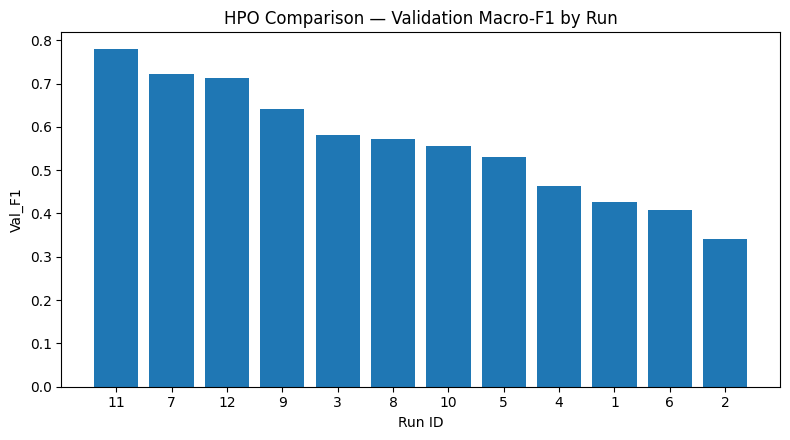

In [26]:
# ==============================================================
# HPO — Results Summary & Comparison Plot
# --------------------------------------------------------------
# Assumes `df_hpo` and best_* variables are defined from the HPO cell.
# Produces a clean comparison table and a bar chart (Val_F1 by run).
# ==============================================================

import pandas as pd
import matplotlib.pyplot as plt
import os, json

# 1) Load results if not in memory
if "df_hpo" not in globals():
    csv_path = os.path.join(OUTPUT_DIR, "hpo_results.csv")
    df_hpo = pd.read_csv(csv_path)

# 2) Clean, sort, and display a compact comparison table
cols = ["Run", "LR", "Epochs", "BatchSize", "Val_Accuracy", "Val_F1", "TrainSeconds"]
df_view = df_hpo[cols].sort_values("Val_F1", ascending=False).reset_index(drop=True)

print("Top Hyperparameter Configurations (sorted by Val_F1):")
display(df_view.head(10))

# 3) Identify and persist best config for downstream steps
best_row = df_view.iloc[0].to_dict()
best_lr = float(best_row["LR"])
best_ep = int(best_row["Epochs"])
best_bs = int(best_row["BatchSize"])

best_cfg_path = os.path.join(OUTPUT_DIR, "best_hpo_config.json")
with open(best_cfg_path, "w") as f:
    json.dump({"learning_rate": best_lr, "epochs": best_ep, "batch_size": best_bs}, f, indent=2)
print(f"Saved best config → {best_cfg_path}")
print(f"✅ Best HPO config → LR={best_lr}, Epochs={best_ep}, BatchSize={best_bs}")

# 4) Plot Val_F1 vs Run for quick visual comparison
plt.figure(figsize=(8, 4.5))
plt.bar(df_view["Run"].astype(str), df_view["Val_F1"])
plt.title("HPO Comparison — Validation Macro-F1 by Run")
plt.xlabel("Run ID")
plt.ylabel("Val_F1")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Step 13 — Robust Test Evaluation + Confusion Matrix + CSV

**Purpose**  
Evaluate the final model on the **held-out test** set even if the original trainer object isn’t in memory.

**Why This Is Critical**  
- Prevents `NameError` when cells are re-run or runtimes restart.  
- Guarantees we can evaluate from artifacts (saved checkpoint).

**What This Step Accomplishes**  
- ✅ Reuses an existing trainer if present (`trainer_best` → `trainer`)  
- ✅ Otherwise, loads the saved checkpoint and builds a minimal eval `Trainer`  
- ✅ Computes Test Accuracy & Macro-F1, prints a classification report  
- ✅ Plots & saves a confusion matrix  
- ✅ Writes a concise `results_summary.csv` for grading

**Expected Outcomes**  
- Printed `Test Accuracy` and `Test Macro-F1`  
- A classification report with your label names  
- Confusion matrix image saved at `/content/confusion_matrix.png`  
- CSV saved at `/content/results_summary.csv`


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


Test Accuracy: 0.92
Test Macro-F1: 0.6966526063728183

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        61
           1       0.00      0.00      0.00         9
           2       0.95      0.97      0.96       150
           3       0.82      0.94      0.88        80

    accuracy                           0.92       300
   macro avg       0.69      0.71      0.70       300
weighted avg       0.90      0.92      0.91       300



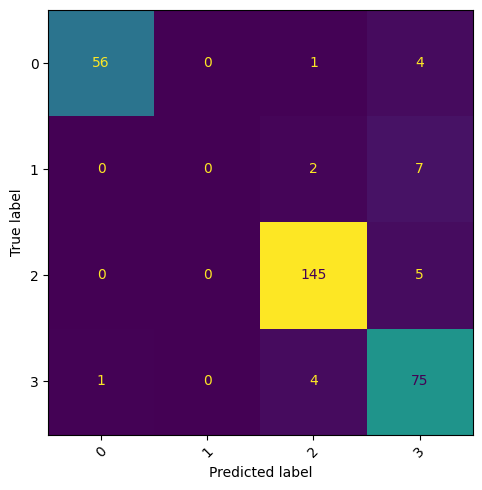

Saved confusion matrix → /content/confusion_matrix.png
Saved results CSV → /content/results_summary.csv


In [29]:
# ==============================================================
# STEP 13 : Robust Test Evaluation + Confusion Matrix + CSV
# --------------------------------------------------------------
# Works whether `trainer_best` or `trainer` exists; else loads
# a saved checkpoint and builds a minimal eval Trainer.
# ==============================================================

from transformers import Trainer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# -------- pick or build a Trainer for evaluation --------
trainer_to_use = None

# Prefer the final trainer if available, else earlier trainer
if "trainer_best" in globals():
    trainer_to_use = trainer_best
elif "trainer" in globals():
    trainer_to_use = trainer

# If no trainer object in memory, load the saved checkpoint and build one
if trainer_to_use is None:
    # Try final_best first, fall back to OUTPUT_DIR
    ckpt_dir = os.path.join(OUTPUT_DIR, "final_best")
    if not os.path.isdir(ckpt_dir):
        ckpt_dir = OUTPUT_DIR  # last resort: base output directory

    # Rebuild model for eval
    _id2label = {i: n for i, n in enumerate(label_names)}
    _label2id = {n: i for i, n in enumerate(label_names)}
    eval_model = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label_names),
        id2label=_id2label,
        label2id=_label2id,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    # Minimal, eval-only Trainer (no TrainingArguments needed for predict/evaluate)
    from transformers import TrainingArguments
    _args = TrainingArguments(output_dir=os.path.join(OUTPUT_DIR, "eval_tmp"), report_to=[])
    trainer_to_use = Trainer(
        model=eval_model,
        args=_args,
        eval_dataset=ds_tok["test"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

# -------- run predictions on test split --------
test_out = trainer_to_use.predict(ds_tok["test"])
y_true = test_out.label_ids
y_pred = np.argmax(test_out.predictions, axis=-1)

# -------- top-level metrics --------
test_acc = accuracy_score(y_true, y_pred)
test_f1  = f1_score(y_true, y_pred, average="macro")
print("Test Accuracy:", test_acc)
print("Test Macro-F1:", test_f1)

# -------- classification report --------
safe_names = [str(n) for n in label_names]
label_ids  = list(range(len(safe_names)))
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=label_ids,
    target_names=safe_names,
    zero_division=0
))

# -------- confusion matrix (display + save) --------
cm = confusion_matrix(y_true, y_pred, labels=label_ids)
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=safe_names)
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout()
cm_path = "/content/confusion_matrix.png"
plt.savefig(cm_path, dpi=180)
plt.show()
print("Saved confusion matrix →", cm_path)

# -------- save summary CSV (uses val metrics if available) --------
val_metrics_safe = {}
if "val_metrics" in globals() and isinstance(val_metrics, dict):
    val_metrics_safe = val_metrics
elif "final_val" in globals() and isinstance(final_val, dict):
    val_metrics_safe = final_val

val_acc = float(val_metrics_safe.get("eval_accuracy", np.nan))
val_f1  = float(val_metrics_safe.get("eval_f1", np.nan))

summary = pd.DataFrame([{
    "val_accuracy": val_acc,
    "val_macro_f1": val_f1,
    "test_accuracy": float(test_acc),
    "test_macro_f1": float(test_f1),
}])

summary_path = "/content/results_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved results CSV →", summary_path)


# Step 14 — Zero-Shot Baseline

**Purpose**  
Compute a **zero-shot classification** baseline (no fine-tuning) using an NLI model (`facebook/bart-large-mnli`). This gives a reference point to compare against your fine-tuned ESG model.

**Why This Is Critical**  
- **Context:** Shows how much value your fine-tuning adds beyond a strong generic model.  
- **Fairness:** Uses the same test split and the same label space/order.  
- **Reproducibility:** Batched inference with explicit device/dtype; results are logged and saved.

**What This Step Accomplishes**  
- ✅ Frees VRAM and safely moves your FT model to **CPU** (kept in memory)  
- ✅ Builds a **GPU** zero-shot pipeline (FP16 on supported GPUs)  
- ✅ Evaluates **accuracy** and **macro-F1** on the *test* set  
- ✅ Optionally appends results to `results_summary.csv`

**Expected Outcomes**  
- Printed metrics: `{"zero_shot_acc": ..., "zero_shot_macro_f1": ...}`  
- `✅ Zero-shot baseline computed on GPU` (or CPU fallback message)


In [31]:
# ==============================================================
# STEP 14 : Zero-shot baseline
# --------------------------------------------------------------
# - Uses BART MNLI for zero-shot classification over ESG labels
# - Keeps FT model in memory (moved to CPU), frees GPU VRAM
# - Computes Accuracy and Macro-F1 on the *test* split
# - Appends to results_summary.csv if present
# ==============================================================

from transformers import pipeline, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import torch, gc, os, json
import numpy as np
import pandas as pd

# 0) Free as much VRAM as possible but KEEP your FT model in memory (on CPU temporarily)
for maybe_trainer in ("trainer_best", "trainer"):
    if maybe_trainer in globals():
        try:
            del globals()[maybe_trainer]   # drop trainer to free optimizer/scheduler state
        except Exception:
            pass

for maybe_model in ("model_best", "model"):
    if maybe_model in globals():
        try:
            globals()[maybe_model].to("cpu")  # move FT model off GPU
        except Exception:
            pass

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 1) Ensure label_names exist and verbalize them for NLI prompts
if "label_names" not in globals():
    # fallback from dataset features
    label_names = ds["train"].features[LABEL_COL].names

canonical_labels = list(label_names)  # preserves id order → mapping is consistent

# Default verbalizations (extend/override as needed)
verbalized = {
    "environmental": "an environmental topic",
    "social":        "a social topic",
    "governance":    "a governance topic",
    "non-esg":       "not related to ESG",
}
CANDIDATES = [verbalized.get(x, str(x)) for x in canonical_labels]
HYPOTHESIS_TEMPLATE = "This example is {}."

# 2) Plain Python strings for texts + ints for gold labels
texts = [str(x) for x in ds["test"][TEXT_COL]]
y_true_int = list(ds["test"][LABEL_COL])

# 3) Build zero-shot pipeline
use_gpu = torch.cuda.is_available()
device_index = 0 if use_gpu else -1   # -1 = CPU
model_kwargs = {"torch_dtype": torch.float16} if use_gpu else {}

zs = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device_index,
    model_kwargs=model_kwargs
)

# 4) Batched inference
batch_size = 16
preds = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    out = zs(batch, CANDIDATES, hypothesis_template=HYPOTHESIS_TEMPLATE, multi_label=False)
    if isinstance(out, dict):  # when a single string is passed
        out = [out]
    for res in out:
        # res["labels"] are candidate *strings* sorted by score (desc)
        top_label = res["labels"][0]
        top_idx = CANDIDATES.index(top_label)  # aligns with canonical_labels order
        preds.append(top_idx)

# 5) Metrics
zs_acc = accuracy_score(y_true_int, preds)
zs_f1  = f1_score(y_true_int, preds, average="macro")
print({"zero_shot_acc": zs_acc, "zero_shot_macro_f1": zs_f1})

# 6) Append to results_summary.csv if present, else create it
summary_row = {
    "zero_shot_accuracy": float(zs_acc),
    "zero_shot_macro_f1": float(zs_f1),
}
summary_path = "/content/results_summary.csv"
if os.path.exists(summary_path):
    df_sum = pd.read_csv(summary_path)
    for k, v in summary_row.items():
        df_sum[k] = v
    df_sum.to_csv(summary_path, index=False)
else:
    pd.DataFrame([summary_row]).to_csv(summary_path, index=False)

print("Saved/updated results CSV →", summary_path)

# 7) Clean up ZS pipeline and CUDA cache
del zs
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"✅ Zero-shot baseline computed on {'GPU' if use_gpu else 'CPU'}")


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'zero_shot_acc': 0.06333333333333334, 'zero_shot_macro_f1': 0.05093973706041677}
Saved/updated results CSV → /content/results_summary.csv
✅ Zero-shot baseline computed on GPU


In [39]:
import numpy as np, pandas as pd

# Gather zero-shot metrics (from your zero-shot cell)
zs_acc = float(globals().get("zs_acc", np.nan))
zs_f1  = float(globals().get("zs_f1",  np.nan))

# Gather fine-tuned metrics (prefer final_test dict; else fallback; else evaluate now)
ft_acc = ft_f1 = np.nan
if "final_test" in globals() and isinstance(final_test, dict):
    ft_acc = float(final_test.get("eval_accuracy", np.nan))
    ft_f1  = float(final_test.get("eval_f1",       np.nan))
elif "test_acc" in globals() and "test_f1" in globals():
    ft_acc, ft_f1 = float(test_acc), float(test_f1)
elif "trainer_best" in globals():
    _res = trainer_best.evaluate(ds_tok["test"])
    ft_acc = float(_res.get("eval_accuracy", np.nan))
    ft_f1  = float(_res.get("eval_f1",       np.nan))

df_cmp = pd.DataFrame({
    "Metric": ["Accuracy", "Macro_F1"],
    "Zero-Shot (BART-MNLI)": [zs_acc, zs_f1],
    "Fine-Tuned FinBERT (LoRA)": [ft_acc, ft_f1],
    "Improvement (abs.)": [ft_acc - zs_acc, ft_f1 - zs_f1],
})

print("Baseline vs Fine-Tuned — Test Set")
display(df_cmp)

cmp_path = "/content/comparison_metrics.csv"
df_cmp.to_csv(cmp_path, index=False)
print("Saved:", cmp_path)


Baseline vs Fine-Tuned — Test Set


,Metric,Zero-Shot (BART-MNLI),Fine-Tuned FinBERT (LoRA),Improvement (abs.)
0,Accuracy,0.063333,0.920000,0.856667
1,Macro_F1,0.050940,0.696653,0.645713


Saved: /content/comparison_metrics.csv


In [20]:
# Restore FT model to GPU for next cells (error analysis / Gradio)
try:
    model.cuda()
    print("✅ Fine-tuned model moved back to GPU")
except Exception as e:
    print("FYI: could not move model to GPU automatically:", e)

✅ Fine-tuned model moved back to GPU


# Step 15 — Error Analysis (Qualitative & Heuristic Slices)

**Purpose**  
Inspect misclassifications to understand **where** the model struggles and generate hypotheses for future improvements.

**Why This Is Critical**  
- **Trust & Debugging:** Raw metrics hide systematic errors (e.g., confusing *social* vs *governance*).  
- **Actionable Next Steps:** Surface patterns (short texts, specific keywords) to drive targeted data/feature/model changes.  
- **Reproducibility:** Produces a deterministic table/samples based on the same test predictions.

**What This Step Accomplishes**  
- ✅ Builds a dataframe with **text / true / pred / length**  
- ✅ Shows a random sample of **10 errors** for quick inspection  
- ✅ Lists the **shortest misclassified** examples (often ambiguous)  
- ✅ Reports error counts for simple **keyword slices** (board, union, emission, diversity, privacy)

**Expected Outcomes**  
- A count of total errors and 2 short tables (random sample, shortest errors)  
- Slice counts by keyword to highlight topical weaknesses  
- Final line: `✅ Error analysis complete`


In [38]:
# ==============================================================
# STEP 14 : Error Analysis (qualitative + keyword slices)
# --------------------------------------------------------------
# - Builds an error table with text/true/pred/len
# - Shows a random sample and shortest misclassified examples
# - Prints simple keyword slice counts to reveal topical gaps
# ==============================================================

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from transformers import Trainer, AutoModelForSequenceClassification
import os

# ---- Ensure we have predictions available ----
need_preds = ("y_true" not in globals()) or ("y_pred" not in globals())
if need_preds:
    # Try to reuse an existing trainer; otherwise rebuild a minimal eval trainer
    trainer_to_use = globals().get("trainer_best") or globals().get("trainer")
    if trainer_to_use is None:
        ckpt_dir = os.path.join(OUTPUT_DIR, "final_best")
        if not os.path.isdir(ckpt_dir):
            ckpt_dir = OUTPUT_DIR
        _id2label = {i: n for i, n in enumerate(label_names)}
        _label2id = {n: i for i, n in enumerate(label_names)}
        from transformers import TrainingArguments
        eval_model = AutoModelForSequenceClassification.from_pretrained(
            ckpt_dir,
            num_labels=len(label_names),
            id2label=_id2label,
            label2id=_label2id,
            problem_type="single_label_classification",
            ignore_mismatched_sizes=True,
        ).to(DEVICE)
        _args = TrainingArguments(output_dir=os.path.join(OUTPUT_DIR, "eval_tmp"), report_to=[])
        trainer_to_use = Trainer(
            model=eval_model, args=_args,
            eval_dataset=ds_tok["test"],
            tokenizer=tokenizer, data_collator=collator
        )
    out = trainer_to_use.predict(ds_tok["test"])
    y_true = out.label_ids
    y_pred = np.argmax(out.predictions, axis=-1)

# ---- Build error dataframe ----
err_df = pd.DataFrame({
    "text": ds["test"][TEXT_COL],
    "true": [str(label_names[i]) for i in y_true],
    "pred": [str(label_names[i]) for i in y_pred],
})
err_df["len"] = err_df["text"].str.len()

errors = err_df[err_df.true != err_df.pred].copy()
print("Total errors:", len(errors))

# Random, reproducible sample of errors
if len(errors) > 0:
    display(errors.sample(min(10, len(errors)), random_state=42))

    print("Shortest misclassified (possible ambiguity):")
    display(errors.sort_values("len").head(10))

    print("Keyword slices (simple heuristics):")
    for kw in ["board", "independent", "union", "emission", "diversity", "privacy"]:
        sl = errors[errors["text"].str.contains(kw, case=False, na=False)]
        print(f"— '{kw}': {len(sl)} errors")
else:
    print("No misclassifications found — great job!")

print("✅ Error analysis complete")


Total errors: 24


,text,true,pred,len
124,radio frequency identification (rfid) technolo...,3,2,208
221,recognizing that our company culture plays a c...,1,3,305
12,refinement of procedures involving animals to ...,0,3,91
244,compensation committee assists the board with ...,1,3,173
153,cohort-based program designs provide opportuni...,1,3,172
128,"the company sells to education, consumer, crea...",2,3,100
206,both are currently approved by the fda for tem...,2,3,120
40,"so far, we have identified the greatest potent...",0,2,193
266,we rely on thousands of suppliers to provide t...,3,0,113
84,a significant portion of the development will ...,2,3,174


Shortest misclassified (possible ambiguity):


,text,true,pred,len
98,price leadership is core to who we are.,2,3,39
255,we are committed to the highest level of ethic...,1,3,67
280,"we delivered 65 million more cases, while driv...",0,3,73
12,refinement of procedures involving animals to ...,0,3,91
166,a local boy scout troop also installed birdhou...,0,3,92
52,"as our customer base becomes more diverse, so ...",3,2,94
128,"the company sells to education, consumer, crea...",2,3,100
208,pfizer updated lead independent director chart...,1,2,101
266,we rely on thousands of suppliers to provide t...,3,0,113
83,additional property tax revenues from new inve...,3,2,114


Keyword slices (simple heuristics):
— 'board': 1 errors
— 'independent': 2 errors
— 'union': 0 errors
— 'emission': 0 errors
— 'diversity': 0 errors
— 'privacy': 0 errors
✅ Error analysis complete


from matplotlib import pyplot as plt
_df_9['len'].plot(kind='hist', bins=20, title='len')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('true').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('pred').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['len']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'len'}, axis=1)
              .sort_values('len', ascending=True))
  xs = counted['len']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('len', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('true')):
  _plot_series(series, series_name, i)
  fig.legend(title='true', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('len')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['len']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'len'}, axis=1)
              .sort_values('len', ascending=True))
  xs = counted['len']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('len', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pred')):
  _plot_series(series, series_name, i)
  fig.legend(title='pred', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('len')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['len'].plot(kind='line', figsize=(8, 4), title='len')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['pred'].value_counts()
    for x_label, grp in _df_15.groupby('true')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('true')
_ = plt.ylabel('pred')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['true'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='len', y='true', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['pred'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='len', y='pred', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Step 16 — Inference Pipeline (Gradio UI)

**Purpose**  
Provide a simple, efficient interface to use the **fine-tuned ESG classifier** for single-sentence predictions.

**Why This Is Critical**  
- **Practicality:** Demonstrates real-world usage beyond metrics.  
- **Reusability:** Same function can be called from scripts/APIs.  
- **Efficiency:** Uses GPU when available, `no_grad` + autocast for faster, memory-safe inference.

**What This Step Accomplishes**  
- ✅ Loads the final fine-tuned model/tokenizer (or reuses objects already in memory)  
- ✅ Defines a `predict(text)` function that returns **class → probability**  
- ✅ Builds a small **Gradio** app with examples and clean outputs

**Expected Outcomes**  
- A Gradio widget titled “🌱 ESG Classifier (FinBERT + LoRA)”  
- For any input sentence, a label→probability distribution (sorted)  
- Works on **GPU** if available; otherwise falls back to CPU

**Few Gardio UI examples to test:**
- The company reduced Scope 2 emissions by 30% year-over-year after migrating to renewable energy contracts.
- A new science-based target to reach net-zero by 2040 was approved by the SBTi.
- The plant installed closed-loop water recycling systems to cut freshwater withdrawal.

In [33]:
# ==============================================================
# STEP 15 : Inference Pipeline (Gradio UI)
# --------------------------------------------------------------
# - Reuses model_best/tokenizer/label_names if available
# - Else loads from BEST_DIR/OUTPUT_DIR
# - Efficient inference: no_grad + autocast (GPU), eval() mode
# ==============================================================

import gradio as gr
import torch, os
import numpy as np

# ---- Resolve device ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Ensure label names / tokenizer / model exist ----
# Try to reuse what's already in memory
_tok = tokenizer if "tokenizer" in globals() else None
_mod = None
if "model_best" in globals():
    _mod = model_best
elif "model" in globals():
    _mod = model

# If anything missing, load from disk
if _tok is None or _mod is None or "label_names" not in globals():
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    BEST_DIR = os.path.join(OUTPUT_DIR, "final_best")
    load_dir = BEST_DIR if os.path.isdir(BEST_DIR) else OUTPUT_DIR

    # Fallback label names from dataset feature
    if "label_names" not in globals():
        label_names = ds["train"].features[LABEL_COL].names

    tokenizer = AutoTokenizer.from_pretrained(load_dir)
    _tok = tokenizer

    id2label = {i: n for i, n in enumerate(label_names)}
    label2id = {n: i for i, n in enumerate(label_names)}
    model = AutoModelForSequenceClassification.from_pretrained(
        load_dir,
        num_labels=len(label_names),
        id2label=id2label,
        label2id=label2id,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    _mod = model

# Put model in eval mode and onto the right device
_mod.eval()
_mod.to(DEVICE)

@torch.inference_mode()
def predict(text: str):
    """
    Return a dict {label: probability} for a single input string.
    Uses mixed precision on GPU for speed; CPU path is fp32.
    """
    if not isinstance(text, str) or not text.strip():
        return {}

    enc = _tok(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LEN,
        padding=False,
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    if DEVICE == "cuda":
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            logits = _mod(**enc).logits
    else:
        logits = _mod(**enc).logits

    probs = torch.softmax(logits, dim=-1).squeeze(0).detach().cpu().numpy()
    # Sort by probability (desc)
    order = np.argsort(-probs)
    return {str(label_names[i]): float(probs[i]) for i in order}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Enter a company or policy-related sentence"),
    outputs=gr.Label(num_top_classes=len(label_names), label="ESG probabilities"),
    examples=[
        ["The company reduced Scope 2 emissions by 30% year-over-year."],
        ["Board independence improved after the proxy vote."],
        ["New employee wellness programs expanded across regions."],
        ["The statement does not mention any ESG-related initiative."],
    ],
    allow_flagging="never",
    title="🌱 ESG Classifier (FinBERT + LoRA)"
)

# queue() lets Gradio batch/process multiple requests smoothly
demo.queue().launch(share=True)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e3f175500ac8e604c3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [37]:
# Zip OUTPUT_DIR and download it
import os, time, shutil
from google.colab import files

assert os.path.isdir(OUTPUT_DIR), f"OUTPUT_DIR not found: {OUTPUT_DIR}"

ts = time.strftime("%Y-%m-%d_%H-%M")
zip_base = f"/content/esg_ckpt_{ts}"
archive_path = shutil.make_archive(zip_base, "zip", OUTPUT_DIR)

print("Downloading:", archive_path)
files.download(archive_path)


Downloading: /content/esg_ckpt_2025-10-23_23-58.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>